In [3]:
import sys

sys.path.append('/Users/robertwelch/Desktop/BIIF/Chiara3/Federico-Pietrocola2022-3/src')

from senolysis_analysis import *
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label

In [4]:
def plot_multi(img_list):

    if isinstance(img_list,list):
        n = len(img_list)

        fig,ax = plt.subplots(1,n)
        fig.set_size_inches(15,15)

        for i,img in enumerate(img_list):
            ax[i].imshow(img,cmap='gray')
    else:
        raise Exception('Input is not a list of images')


In [111]:
def find_features(mask,red_downscaled,green_downscaled,blue_downscaled):

    nuclei_scenenst = regionprops(label(mask),intensity_image=red_downscaled)
    nuclei_quiescent = regionprops(label(mask),intensity_image=green_downscaled)
    nuclei_regions = regionprops(label(mask),intensity_image=blue_downscaled)

    red_intensities = []
    green_intensities = []
    nuclei_intentisies = []
    nuclei_size = []
    for i in range(len(nuclei_quiescent)):
        red_intensities.append(nuclei_scenenst[i].mean_intensity)
        green_intensities.append(nuclei_quiescent[i].mean_intensity)
        nuclei_intentisies.append(nuclei_regions[i].mean_intensity)
        nuclei_size.append(nuclei_regions[i].area)


    X = np.zeros([len(green_intensities),4])
    X[:,0] = red_intensities
    X[:,1] = green_intensities
    X[:,2] = nuclei_intentisies
    X[:,3] = nuclei_size
    
    #Normalize for each image
    #X = X/X.max(axis=0)

    return X

def remove_well_rings(img,max_size = 150):
        from skimage.filters import threshold_mean
        from skimage.morphology import binary_dilation,disk
        from skimage.segmentation import flood_fill


        thresh = threshold_mean(img)
        binary = img > thresh
        regions = regionprops(label(binary))
        # Generate mask of regions below max_size
        removal_mask = np.zeros(img.shape, dtype="bool")
        for region in regions:
            if max_size < region.area:
                removal_mask[tuple(region.coords.T.tolist())] = 1

        #Dilate slightly to ensure well-edge is completely removed
        removal_mask = binary_dilation(removal_mask,disk(15))

        #fill corners of image (Outside of well)
        removal_mask = flood_fill(removal_mask, (0, 0), 1)
        removal_mask = flood_fill(removal_mask, (-1, 0), 1)
        removal_mask = flood_fill(removal_mask, (0, -1), 1)
        removal_mask = flood_fill(removal_mask, (-1, -1), 1)

        #invert mask
        removal_mask = np.abs(removal_mask-1)

        out = removal_mask * img
        return out, removal_mask

In [118]:
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB08_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0036.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB11_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0054.nd2'
#def main(img_path):
    
red, green, blue = nd2_import(img_path)

downscale_factor = 4
blue_downscaled = downscale_local_mean(
    blue, factors=(downscale_factor, downscale_factor)
)
green_downscaled = downscale_local_mean(
    green, factors=(downscale_factor, downscale_factor)
)
red_downscaled = downscale_local_mean(
    red, factors=(downscale_factor, downscale_factor)
)

# normalize to [0,1] for 0 to 99th percentiles
red_norm, green_norm, blue_norm = (
    normalize_img(red_downscaled, high_per=98),
    normalize_img(green_downscaled, high_per=98),
    normalize_img(blue_downscaled, high_per=98),
)

# downscale the images for faster computation @300ms each


# Smooth the blue channel for nuclei segmentation
blue_smoothed = gaussian(blue_norm, 1)  # smooth image

# remove the well ring from the blue channel
blue_no_well_ring, removal_mask = remove_well_rings(blue_smoothed)

nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)
nuclei_thresholded_upscaled = remove_small_objects(nuclei_thresholded,min_size=50)
nuclei_thresholded_upscaled = remove_large_nuclei(nuclei_thresholded,1000)
nuclei_thresholded_upscaled = resize(nuclei_thresholded, output_shape=blue.shape)



# Determine if each nuclei belongs to scenescent or quiescent cell #500ms

X = find_features(nuclei_thresholded,red_downscaled,green_downscaled,blue_downscaled)



Text(0.5, 0, 'red Intensities')

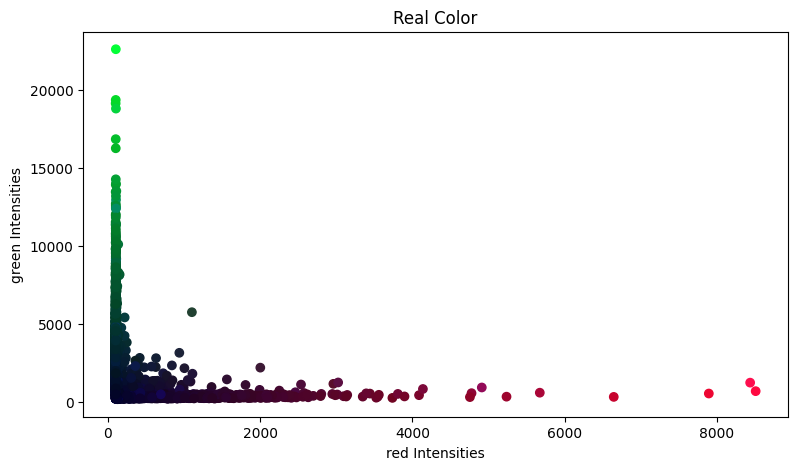

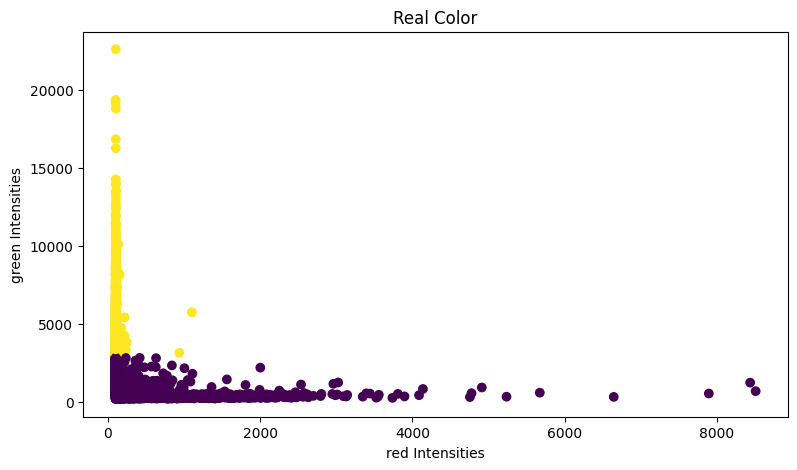

In [124]:
from sklearn.cluster import KMeans

X_for_clustering = X[:,:]

kmeans = KMeans(n_clusters=2, random_state=0,init='random').fit(X_for_clustering)


#X_color_01 = np.zeros([len(X),3])
X_color_01 = X[:,:3]/X[:,:3].max(axis=0) # have to normalize colours
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Real Color')
plt.scatter(X[:,0],X[:,1],c = X_color_01)
plt.ylabel('green Intensities')
plt.xlabel('red Intensities')


X_color_01 = np.zeros([len(X),3])
X_color_01[:,:2] = X[:,:2]/X[:,:2].max(axis=0) # have to normalize colours
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Real Color')
plt.scatter(X[:,0],X[:,1],c = kmeans.labels_)
plt.ylabel('green Intensities')
plt.xlabel('red Intensities')


In [116]:
X.shape

(4583, 4)

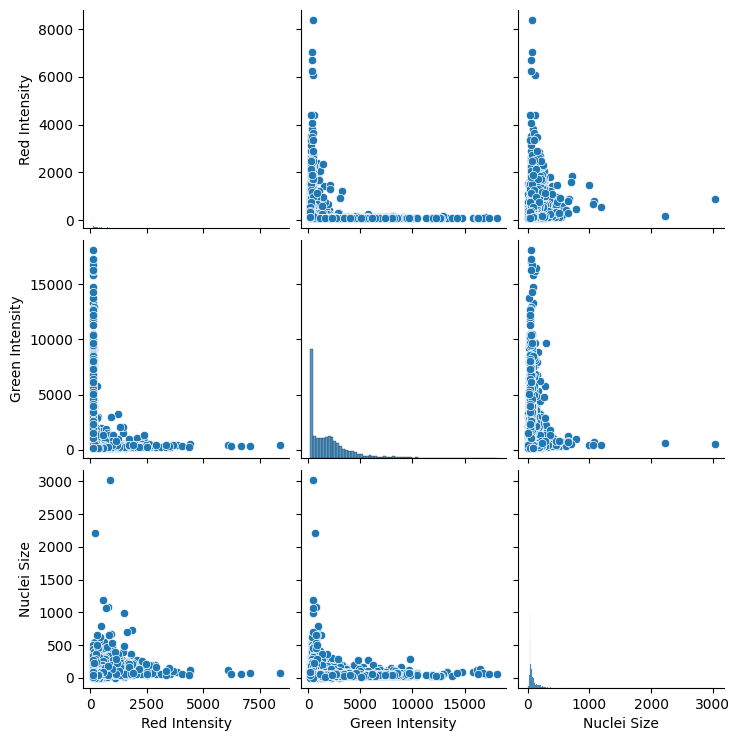

In [45]:
import seaborn as sns

df = pd.DataFrame(X,columns=['Red Intensity','Green Intensity','Nuclei Size'])
sns.pairplot(df)

